Installs and imports

In [ ]:
! pip install imbalanced-learn

In [ ]:
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/ThyroidDis.csv

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import pipeline

plt.rcParams['figure.figsize'] = 10, 10
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## 1. Description of dataset

    1. Many attributes (29)
    2. mostly numeric or Boolean valued attributes
    3. thyroid disease domains (records provided by the Garavan Institute
       of Sydney, Australia)
    4. several missing attribute values (signified by "?")
    5. small number of classes (4)-> target
    7. 3771 instances in data set

## 2. General overview of the data

Let's do some initial overview of the whole dataset before checking every variable

In [ ]:
# reading the data
df = pd.read_csv('ThyroidDis.csv')

In [ ]:
# Checking for duplicates
df[df.duplicated(keep='last')]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
39,64,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
92,26,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
104,57,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
204,26,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
210,64,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690,55,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
2753,51,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
2800,35,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
2908,65,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative


In [ ]:
# Deleting duplicated records
df = df.drop_duplicates()

In [ ]:
# Replacing ? with NaN for future preprocessing
df.replace('?', np.nan, inplace=True)

In [ ]:
# Checking for variables with all NaNs
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3711 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3710 non-null   object 
 1   sex                        3562 non-null   object 
 2   on_thyroxine               3711 non-null   object 
 3   query_on_thyroxine         3711 non-null   object 
 4   on_antithyroid_medication  3711 non-null   object 
 5   sick                       3711 non-null   object 
 6   pregnant                   3711 non-null   object 
 7   thyroid_surgery            3711 non-null   object 
 8   I131_treatment             3711 non-null   object 
 9   query_hypothyroid          3711 non-null   object 
 10  query_hyperthyroid         3711 non-null   object 
 11  lithium                    3711 non-null   object 
 12  goitre                     3711 non-null   object 
 13  tumor                      3711 non-null   objec

In [ ]:
# Dropping TBG as it has only NaNs 
df.drop('TBG', axis=1, inplace=True)

In [ ]:
# General description of the data
df.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,Class
count,3710,3562,3711,3711,3711,3711,3711,3711,3711,3711,3711,3711,3711,3711,3711,3711,3711,3402,3711,3002,3711,3540,3711,3384,3711,3386,3711,3711,3711
unique,93,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,287,2,69,2,241,2,146,2,234,1,5,4
top,59,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.2,t,2,t,101,t,0.99,t,100,f,other,negative
freq,95,2424,3247,3661,3669,3564,3658,3658,3652,3477,3477,3693,3677,3615,3710,3527,3402,116,3002,237,3540,71,3384,95,3386,73,3711,2140,3420


Next conclusions from the description:
* TSH, T3, TT4, T4U, FTI and age are actually numerical data, better to change their datatype
* TBG_measured has only 1 type of outcome, so can be dropped
* referral_source has most frequent 'other' value which is actually the same as NaN from informational point of view, so need to check percentage and most probably drop this feature
* Most of features are categorical with binary nature

In [ ]:
# Dropping TBG_measures
df.drop('TBG_measured', axis=1, inplace=True)

In [ ]:
# Checking percentage of other value in referral_source feature
df.referral_source.value_counts(True)

other    0.576664
SVI      0.278631
SVHC     0.104015
STMW     0.030181
SVHD     0.010509
Name: referral_source, dtype: float64

In [ ]:
# Dropping referral_source as it has very big percentage of other(can be assumed as NaNs)
df.drop('referral_source', axis=1, inplace=True)

In [ ]:
# Creating list of numerical features
num_columns = ['age', 'T3', 'TSH', 'TT4', 'T4U', 'FTI']

In [ ]:
# Changing datatype to float for numerical features
df[num_columns] = df[num_columns].astype(float)

## 3. EDA

Before analysis itself let's create some functions for plotting

In [ ]:
# Function for 1 barplot visualization
def bar_plot(column, data):
    sns.countplot(x = column, data = data)
    plt.xlabel(column.title())
    plt.ylabel("Count")
    plt.title(f'{column.title()} Distribution')
    
# Helping function for complex plotting
def plot(column, ax):
    sns.countplot(x = column, data = df, ax = ax)
    ax.set_xlabel(column.title())
    ax.set_ylabel("Count")
    ax.set_title(f'{column.title()} Count')

# Function for 2 barplots visualization     
def bar_plot2(column1, column2):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
    plot(column1, ax1)
    plot(column2, ax2)

### 3.1. Univariate analysis

#### **Target**
Let's check what we have for Class variable.

In [ ]:
# Checking percentage of null values
df.Class.isna().sum()/len(df)

0.0

* We don't have nulls for target

In [ ]:
# Checking values percentage for target
df.Class.value_counts(True)

negative                   0.921584
compensated_hypothyroid    0.052277
primary_hypothyroid        0.025600
secondary_hypothyroid      0.000539
Name: Class, dtype: float64

* There are 4 types of outcomes for Class variable, which means we have multiclass classification problem
* Looks like our data is very unbalanced, let's see how it looks on barplot

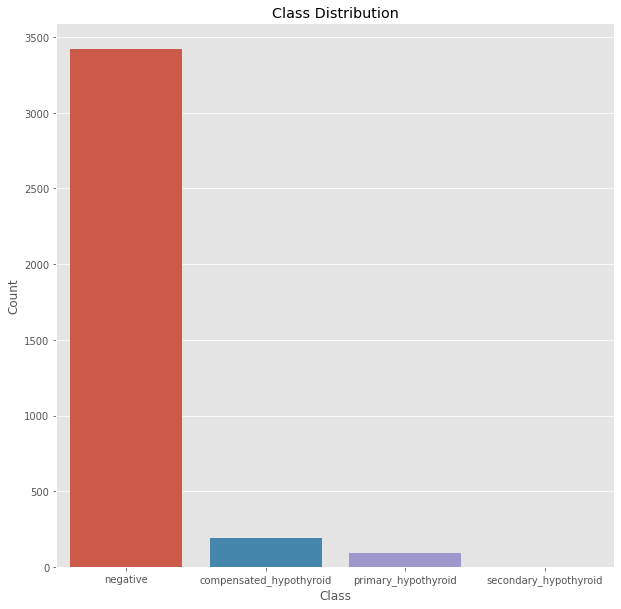

In [ ]:
# Visualization for target variable
bar_plot('Class', df)

* Most frequent class is negative class here and it has >90% of data, it is majority class
* Secondary_hypothyroid has very small amount of values, it is minority class
* Balancing should be done for this dataset

#### **Numerical features**

Let's check distributions of numerical features.

Also I've added boxplots to check relations of numerical features with Class to see if there are any relations.

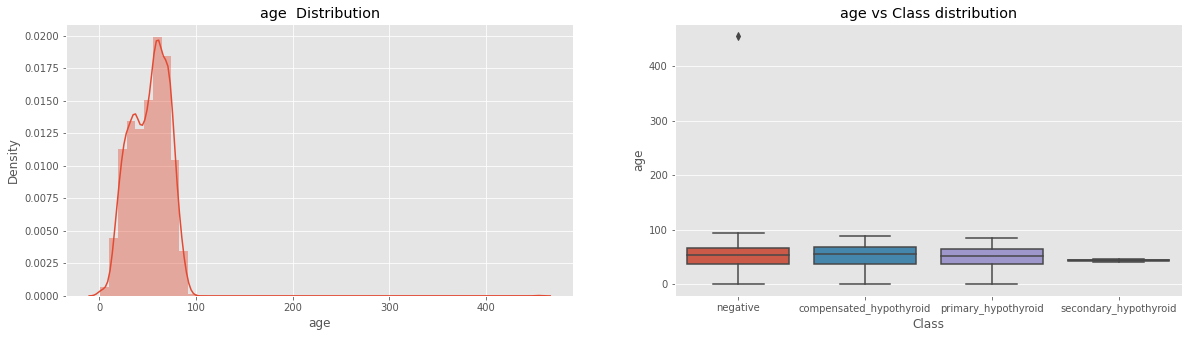

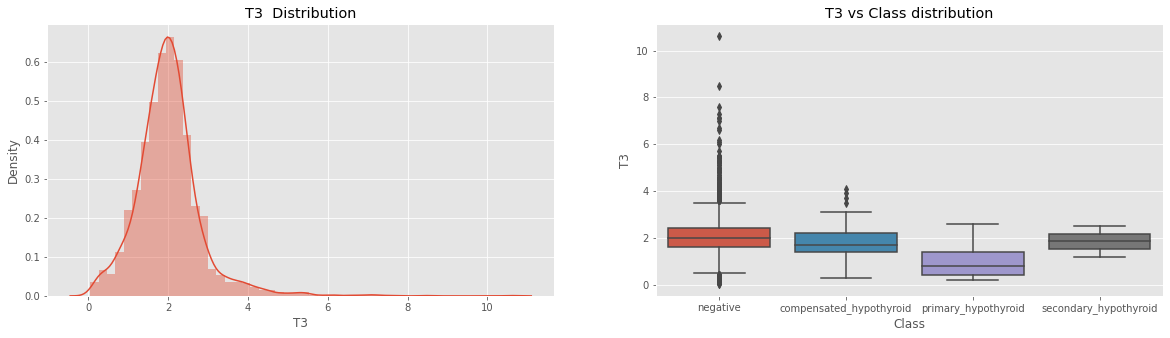

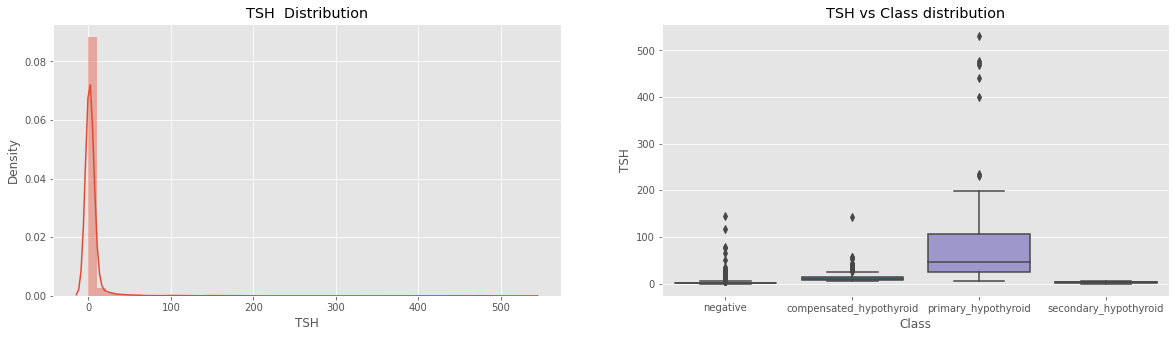

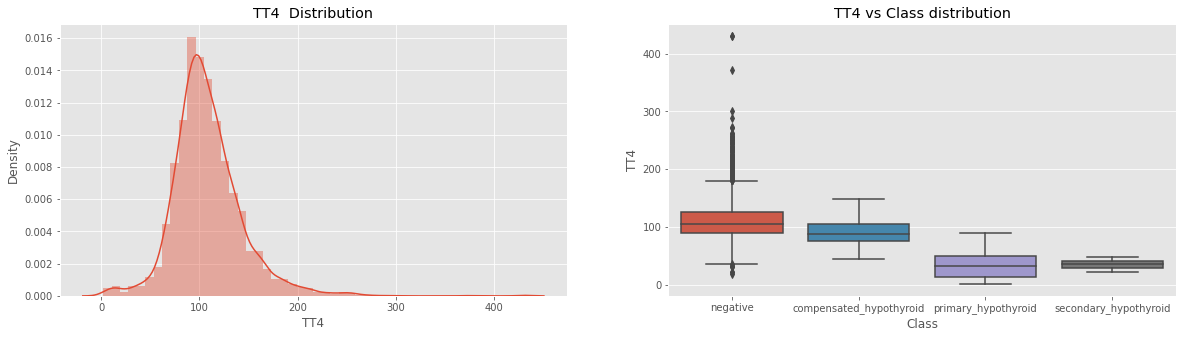

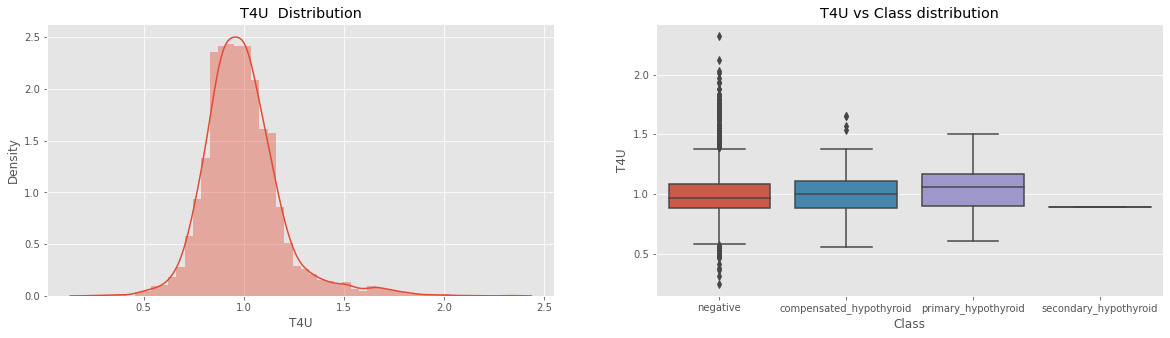

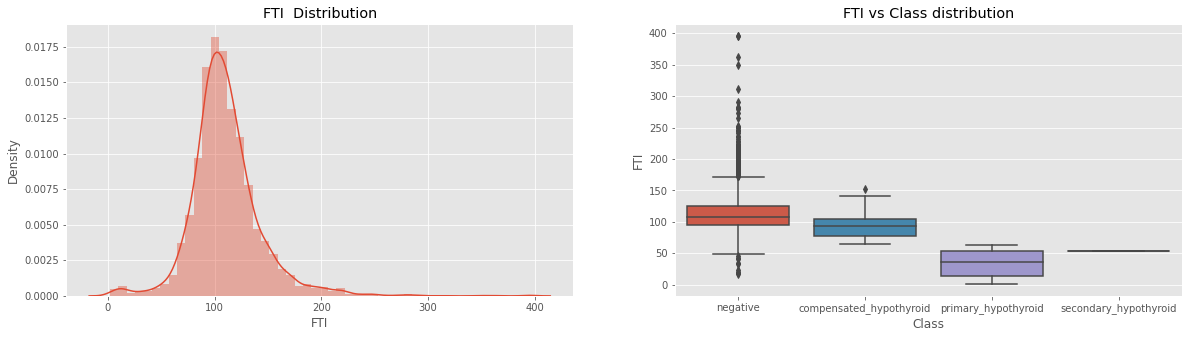

In [ ]:
# Visualization for numerical features distributions separately and with Target 

for column in num_columns:

    plt.figure(figsize=(20,5))

    plt.subplot(1,2,1)
    sns.distplot(df[column])
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'{column}  Distribution')

    plt.subplot(1,2,2)
    sns.boxplot(x='Class', y=column, data=df)
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.title(f'{column} vs Class distribution')

* From histogram we can see that for most of numerical features distributions look good, even pretty close to normal
* There are outliers for all numerical features
* TSH feature deviates from the normal distribution very much, has appreciable positive skewness and shows peakedness
* TSH will need some transformation
* Regarding relations with target TSH, TT4 and FTI have some relations but it will be estimated in next section


#### **Categorical features**

Let's check the distributions for categorical features.

In [ ]:
# Categorical pairs for plotting
cat_columns_pairs = [['sex', 'on_thyroxine'],
               ['query_on_thyroxine', 'on_antithyroid_medication'],
               ['sick', 'pregnant'],
               ['thyroid_surgery', 'I131_treatment'],
               ['query_hypothyroid', 'query_hyperthyroid'],
               ['lithium', 'goitre'], 
               ['tumor', 'hypopituitary'], 
               ['psych', 'TSH_measured'],
               ['T3_measured', 'TT4_measured'],
               ['T4U_measured', 'FTI_measured']]

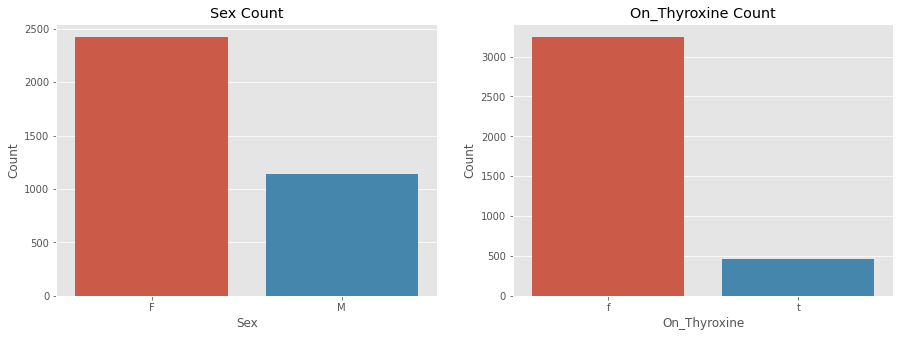

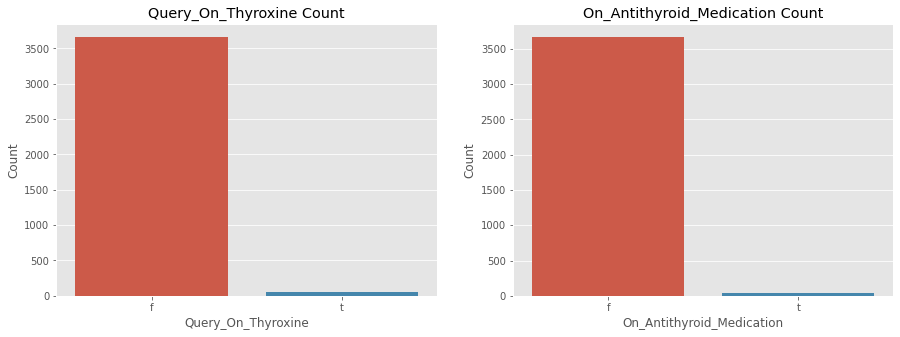

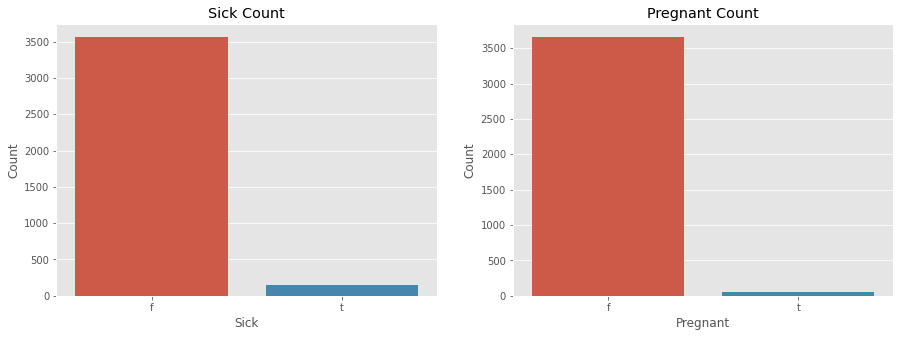

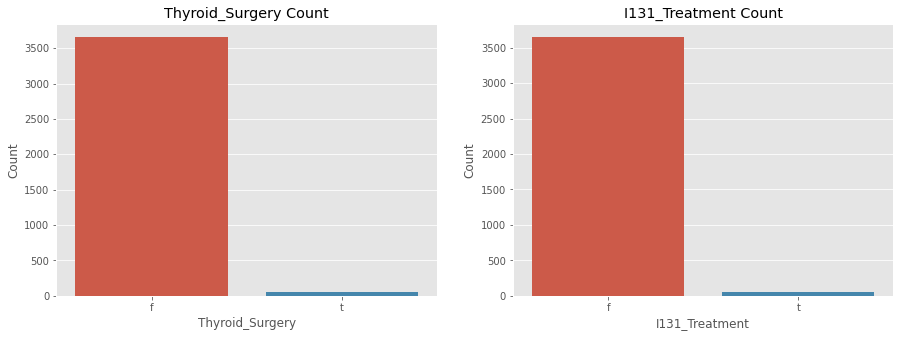

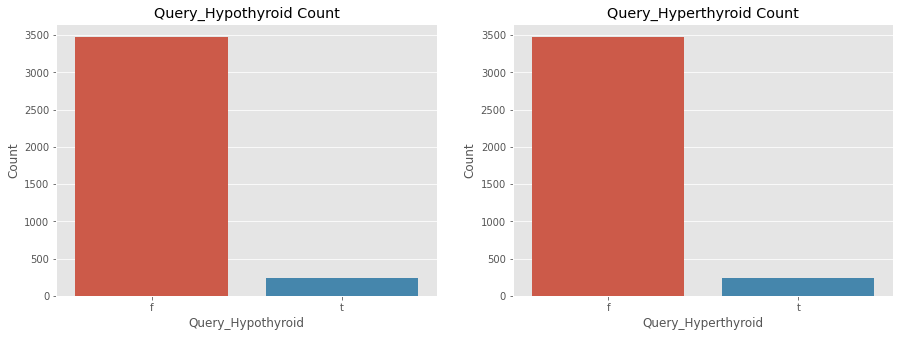

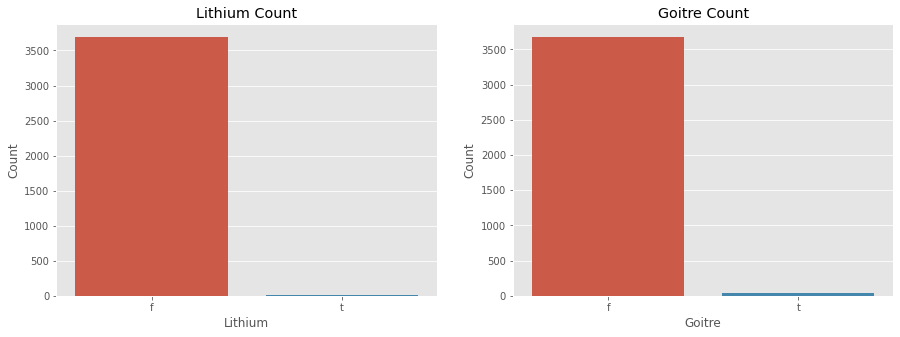

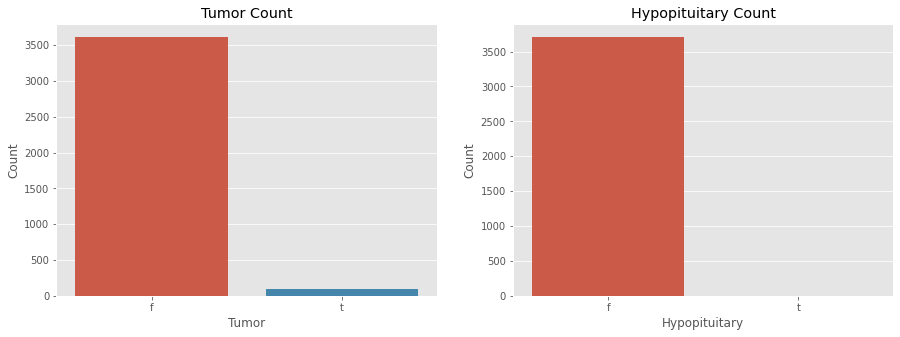

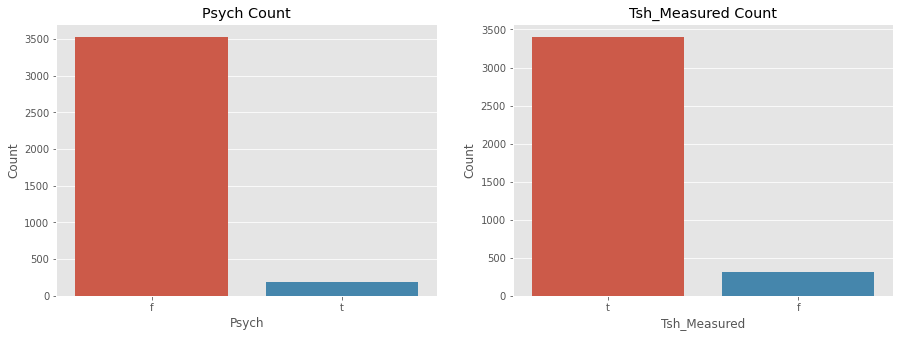

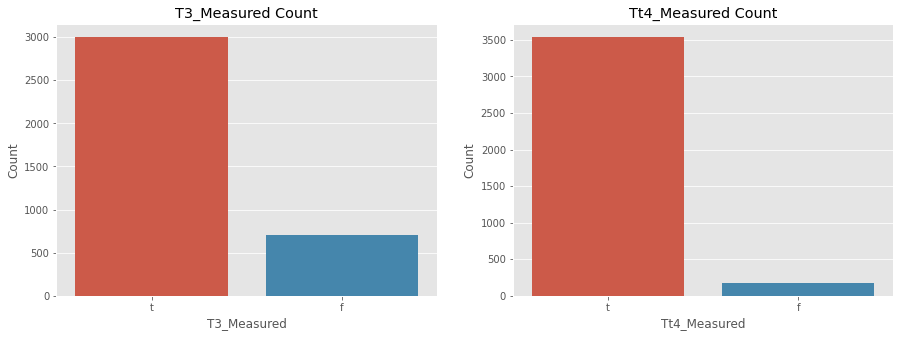

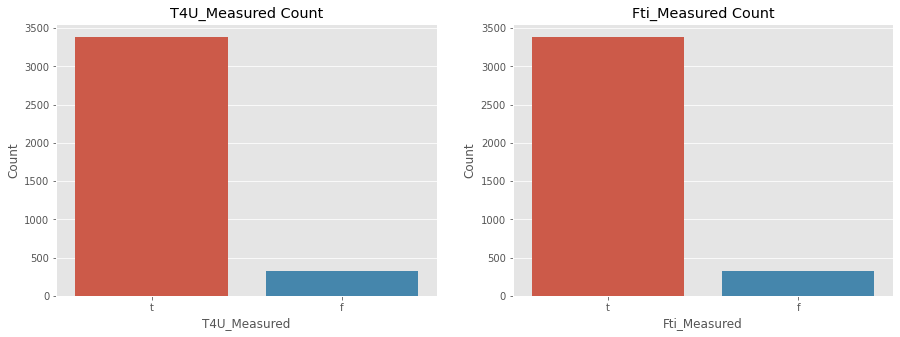

In [ ]:
# Visualization for categorical variables
for column in cat_columns_pairs:
  bar_plot2(column[0], column[1])

* From barplots we can see that all categorical features have binary nature, most of them false/true and only for sex it is male/female
* For most features false is highly dominant value
* For sex there is bigger part of female values then male
* For features from group *_Measured true is dominant 
* There are some features which are presented with mostly 1 value and most probably they will not give us any insights in the future, so they will be dropped

In [ ]:
# Adding features for dropping to the list
features_for_dropping = ['query_on_thyroxine',
                         'on_antithyroid_medication',
                         'sick',
                         'pregnant',
                         'thyroid_surgery',
                         'I131_treatment',
                         'lithium',
                         'goitre',
                         'hypopituitary']

In [ ]:
# dropping features from the list 
for column in features_for_dropping:
  df.drop(column, axis=1, inplace=True)
  print(column, ' dropped')

query_on_thyroxine  dropped
on_antithyroid_medication  dropped
sick  dropped
pregnant  dropped
thyroid_surgery  dropped
I131_treatment  dropped
lithium  dropped
goitre  dropped
hypopituitary  dropped


### 3.2. Multivariate analysis

#### **Numerical features relations including target**

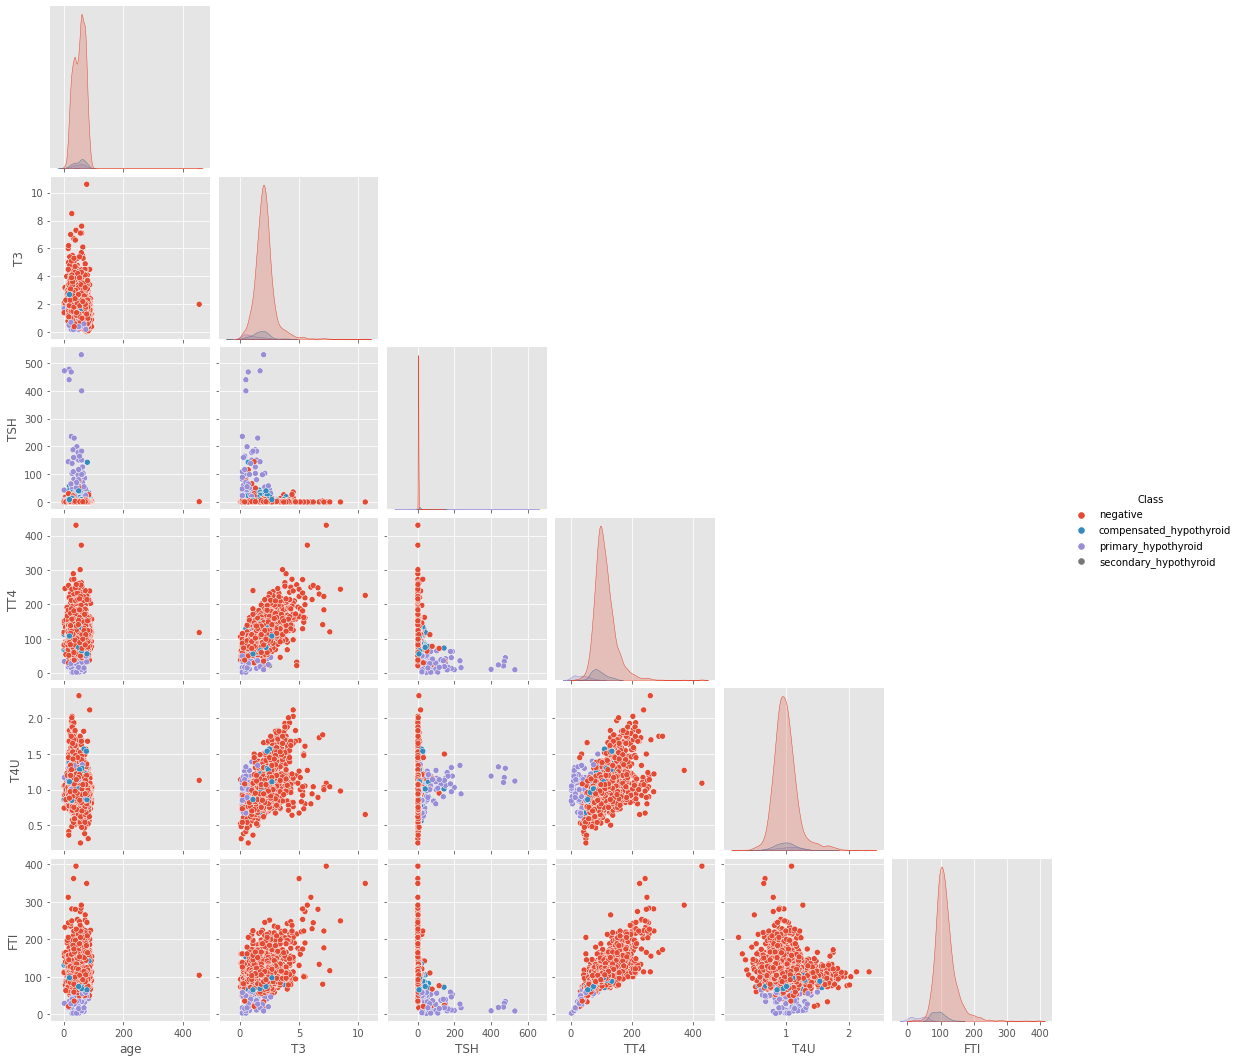

In [ ]:
# Visualization for target vs numerical features relations
sns.pairplot(
    df,
    x_vars=num_columns,
    y_vars=num_columns,
    corner=True,
    hue = 'Class'
)

* From this pairplot it is visible that T3 has some correlation with FTI, T4U, TT4, and TT4 with FTI and may be T4U
* Regarding target there is some relation between TSH, TT4, T3, FTI and target, for TSH it's positive , for T3, FTI and TT4 it's negative
* Age and T4U don't have any significant impact on target

#### **Correlation analysis**

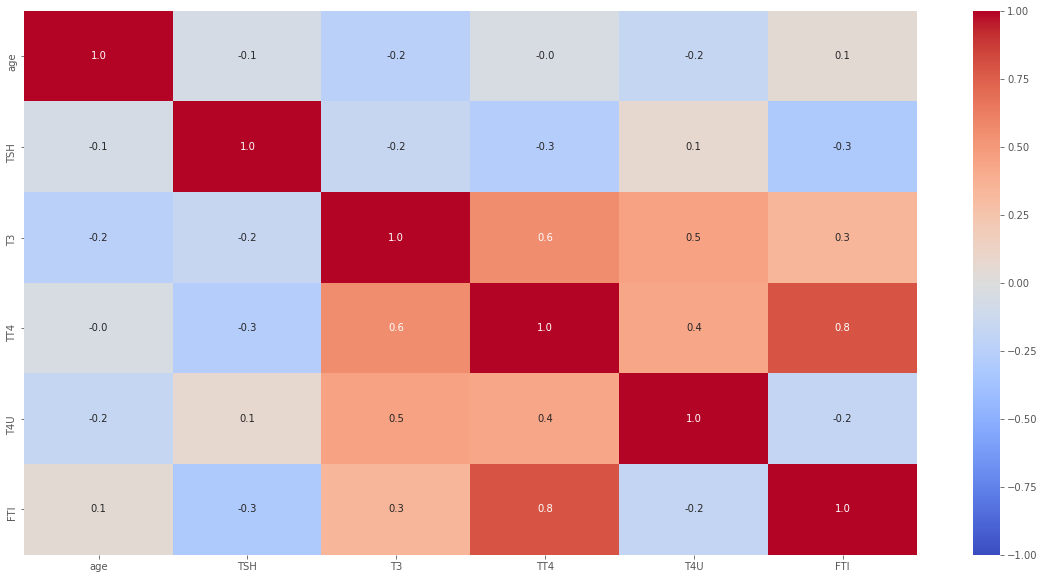

In [ ]:
# Visualization for correlation between numerical features
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(df.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm')

* Here we have 2 features with strong correlation TT4 and FTI, so it would be good to delete 1 to avoid multicolinearity problem, but for now more investigation needed

* It would be good to check how severity of thyroid tumor is correlated to numerical features, but for this we need to change target values to numbers

In [ ]:
# To make sure every value is encoded correctly dictionary and map are used
# the higher severity, the higher number
vals_to_replace = {'negative': 0, 'compensated_hypothyroid':'1', 'primary_hypothyroid':'2', 'secondary_hypothyroid': 3 }
df.Class = df.Class.map(vals_to_replace).astype(int)

In [ ]:
# Correlation for target with numerical features using Kendall coeficient
df.corr(method='kendall')['Class'].sort_values()

FTI     -0.249103
TT4     -0.228690
T3      -0.161990
age     -0.000649
T4U      0.040476
TSH      0.389508
Class    1.000000
Name: Class, dtype: float64

In [ ]:
# Correlation for target with numerical features using Spearman coeficient
df.corr(method='spearman')['Class'].sort_values()

FTI     -0.302223
TT4     -0.278176
T3      -0.195069
age     -0.000753
T4U      0.049499
TSH      0.471299
Class    1.000000
Name: Class, dtype: float64

* So for target most important features are TSH and FTI
* TSH has moderate positive correlation with target
* FTI, TT4, T3 have weak moderate negative correlation with target
* Age and T4U have very close to zero correlation with target

## 4. Data preprocessing

Some useful functions before the section

In [ ]:
# Function for deleting rows with outliers due to 1.5IQR rule
def drop_outliers(data, column):
    Q1, Q3 = np.percentile(column,[25,75])
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5*IQR)
    upper_limit = Q3 + (1.5*IQR)
    df.drop(df[column<lower_limit].index, inplace=True)
    df.drop(df[column>upper_limit].index, inplace=True)
    print('Outliers deleted')

### 4.1. Missing values

Now will check whare we have missing values

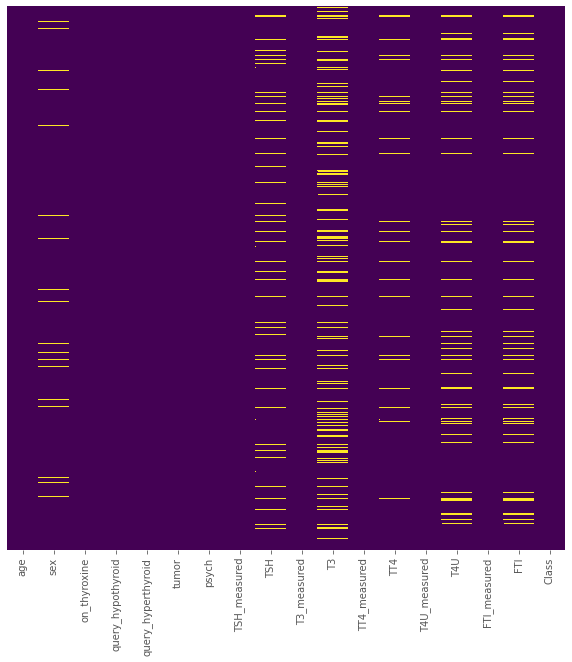

In [ ]:
# Visualization for missing values
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [ ]:
# Percentage of missing values for each feature
df.isna().sum()/len(df)

age                   0.000269
sex                   0.040151
on_thyroxine          0.000000
query_hypothyroid     0.000000
query_hyperthyroid    0.000000
tumor                 0.000000
psych                 0.000000
TSH_measured          0.000000
TSH                   0.083266
T3_measured           0.000000
T3                    0.191054
TT4_measured          0.000000
TT4                   0.046079
T4U_measured          0.000000
T4U                   0.088116
FTI_measured          0.000000
FTI                   0.087577
Class                 0.000000
dtype: float64

* We can see that T3 has more then 15% of missing values so it is better to drop it
* For numerical features there are less then 9% of missing values, so it is safe to change them to median value
* For categorical features missing values are less then 5% so they will be replaced with most frequent value
* Replacing will be done in next section

In [ ]:
# Dropping feature T3
df.drop('T3', axis=1, inplace=True)

In [ ]:
# Removing T3 from list of numerical columns
num_columns.remove('T3')

### 4.2. Outliers

In [ ]:
# Statistics for numerical features
df.describe()

,age,TSH,TT4,T4U,FTI,Class
count,3710.000000,3402.000000,3540.000000,3384.000000,3386.000000,3711.000000
mean,51.860377,5.087820,108.328475,0.994989,110.480715,0.105093
std,20.123585,24.524998,35.605132,0.195485,33.088316,0.385385
min,1.000000,0.005000,2.000000,0.250000,2.000000,0.000000
25%,36.000000,0.500000,88.000000,0.880000,93.000000,0.000000
50%,54.000000,1.400000,103.000000,0.980000,107.000000,0.000000
75%,67.000000,2.700000,124.000000,1.080000,124.000000,0.000000
max,455.000000,530.000000,430.000000,2.320000,395.000000,3.000000


* As we can see almost for every feature we has ouliers
* For dropping them we select method with 1.5(IQR) as it deletes extreme values, but still left pretty much rows which can be useful for other features

In [ ]:
# Deleting extreme outliers
for column in num_columns:
  drop_outliers(df, df[column])

Outliers deleted
Outliers deleted
Outliers deleted
Outliers deleted
Outliers deleted


### 4.3. Categorical encoding

First we need to separate numerical, categorical and target columns

In [ ]:
# Checking datatypes of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3711 entries, 0 to 3771
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 3710 non-null   float64
 1   sex                 3562 non-null   object 
 2   on_thyroxine        3711 non-null   object 
 3   query_hypothyroid   3711 non-null   object 
 4   query_hyperthyroid  3711 non-null   object 
 5   tumor               3711 non-null   object 
 6   psych               3711 non-null   object 
 7   TSH_measured        3711 non-null   object 
 8   TSH                 3402 non-null   float64
 9   T3_measured         3711 non-null   object 
 10  TT4_measured        3711 non-null   object 
 11  TT4                 3540 non-null   float64
 12  T4U_measured        3711 non-null   object 
 13  T4U                 3384 non-null   float64
 14  FTI_measured        3711 non-null   object 
 15  FTI                 3386 non-null   float64
 16  Class 

In [ ]:
# Separating numerical from categorical data
NUMERICAL_FEATURES = num_columns
CATEGORICAL_FEATURES = [
  'sex',
  'on_thyroxine',
  'query_hypothyroid',
  'query_hyperthyroid',
  'tumor',
  'psych',
  'TSH_measured',
  'T3_measured', 
  'TT4_measured',
  'T4U_measured',
  'FTI_measured'
]
TARGET = ['Class']

* As for all categorical features we have binary values we can just replace them with 1 and 0 and it will be all encoding for the dataset
* Class values are already replaced with ordinal values in previous section

In [ ]:
# Replacing all trues and falses with 1 and 0
df.replace('f', 0, inplace=True)
df.replace('t', 1, inplace=True)

# Replacing all Male and Female with 1 and 0
df.replace('F', 0, inplace=True)
df.replace('M', 1, inplace=True)

### 4.4. Imputing missing values and scaling transformation

In [ ]:
# Copy our data to new train dataframe
train = df

* As already was mentioned missing values are represented by small percentage in dataset
* So for numerical features missing values will be imputed with median and for categorical with most frequent value
* For scaling robust scaler was used as we still can have outliers and for some numerical features distribution deviates from normal

In [ ]:
# Using gen_features function to impute missing values and scale numerical data
# Numerical
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL_FEATURES],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': RobustScaler}
    ]
)
# Categorical
categorical_def = gen_features(
    columns=[[c] for c in CATEGORICAL_FEATURES],
    classes=[
        {'class': SimpleImputer, 'strategy': 'most_frequent'}
    ]
)

In [ ]:
# Using mapper for transformation
features = numerical_def + categorical_def
mapper = DataFrameMapper(features)
len(features)

16

In [ ]:
# Separating Target and rest of features
y = train[TARGET]
X = train.drop(TARGET, axis=1)
SEED = 42

In [ ]:
# Transforming dependent variables
X_tr = pd.DataFrame(mapper.fit_transform(X))

## 5. Models

### 5.1. Metrics

For estimating our models next one metrics were selected:
1. **F1 score**:
    * a single score that kind of represents both Precision(P) and Recall(R), which means we both estimating false negative and false positive

2. **Recall**: 
    * recall gives us information about a classifier’s performance with respect to false negatives (how many did we miss), which is very important thing during diagnostic thyroid diseases

3. **Precision**:
    * gives us information about a classifier’s performance with respect to false positives(how many did we caught), which less important for thyroid diseases, but still it is good to check

4. For visualization confusion matrix will be used

5. As our dataset is very unbalanced it is not correct to use Accuracy as a metric, but I'll include it just for comparing models accuracy before and after fixing unbalancing

6. For metrics classification_report function will be used so more metrics will be displayed but most important for us are **F1 and Recall**

7. For cross-validation KFold will be used with 5 splits

In [ ]:
# Function for evaluating the model with mentioned metrics
# Accuracy is printed separately from report as well to see decimal points
def evaluate_model(X_t, y_t, X_v, y_v, model):
  acc = model.score(X_v, y_v)*100
  print("Test Accuracy {:.2f}%".format(acc))
  print(classification_report(y_v, predictions))


In [ ]:
# Function for printing confusion matrix
def conf_matrix(y_v, preds, model_name):
  class_names = ['negative', 'compensated', 'primary', 'secondary']
  conf = confusion_matrix(y_v, preds)
  sns.heatmap(conf,
            annot=conf/np.sum(conf,axis=1),
            yticklabels=class_names,
            xticklabels=class_names,
            cmap="Blues"
            );
  plt.title(model_name +' confusion matrix');
  plt.xlabel('Predicted value');
  plt.ylabel('True value');
  # plt.yticks(rotation=45)

In [ ]:
# Function for cross_validation of the model
def cross_validate(model, X_v, y_v, cv):
   scores = cross_val_score(model, X_v, y_v, cv=cv)
   print('Cross-Validation Accuracy Scores:\n', scores)
   scores = pd.Series(scores)
   print('-------------------------------------------')
   print('Mean score: ', scores.mean())

### 5.2. Logistic regression

In [ ]:
# Splitting values to train and test sets with 20% of data for validation
X_train, X_test, y_train, y_test = train_test_split(X_tr, y, random_state=SEED, test_size = 0.2)

####**with regularization**

In [ ]:
# Logistic regression model with default regularization which is l2
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [ ]:
# Evaluating the model
evaluate_model(X_train, y_train, X_test, y_test, lr)

Test Accuracy 96.37%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       681
           1       0.91      0.48      0.62        42
           2       0.90      0.95      0.93        20

    accuracy                           0.96       743
   macro avg       0.93      0.81      0.84       743
weighted avg       0.96      0.96      0.96       743



* For our dataset the most important metrics are recall and f1-score as we don't want to miss false negatives for thyroid diseases
* And from the report we can see that recall and f1 is not very good for 1 class(which is compensated hypothyroid)
* Accuracy is not informative in this case as we have not balanced data, but it statys in report for comparing after data will be balanced

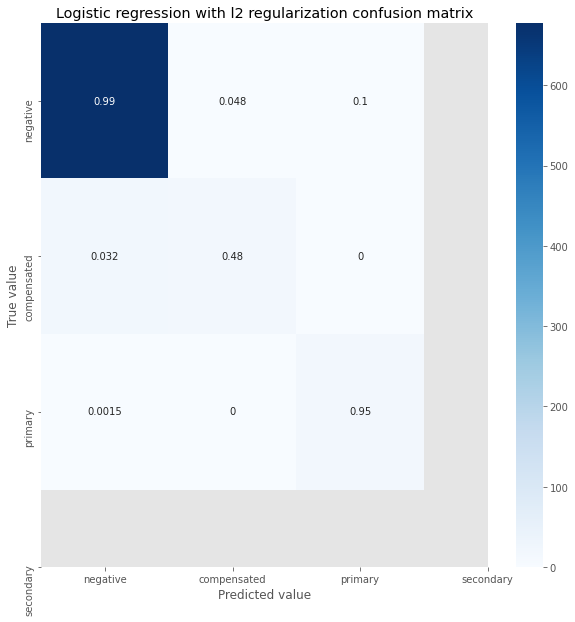

In [ ]:
# Confusion matrix visualization for the model with l2 regularization
conf_matrix(y_test, predictions, 'Logistic regression with l2 regularization')

* From confusion matrix we can see that secondary hypothyreoid (Class value 3) wasn't even included in our test data as it has only 2 samples of records, and we have good results only for negative class

In [ ]:
# Cross-validation for the model
cross_validate(lr, X_test, y_test, 5)

Cross-Validation Accuracy Scores:
 [0.95302013 0.9261745  0.93959732 0.9527027  0.94594595]
-------------------------------------------
Mean score:  0.9434881189914746


* Cross validations shows us pretty good results but still we need to improve our model

####**without regularization**

In [ ]:
# Logistic regression model without regularization
lr_wo = LogisticRegression(penalty='none')
lr_wo.fit(X_train, y_train)
predictions = lr_wo.predict(X_test)

In [ ]:
# Evaluating linear regression model without regularization
evaluate_model(X_train, y_train, X_test, y_test, lr_wo)

Test Accuracy 96.90%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       681
           1       0.89      0.60      0.71        42
           2       0.86      0.95      0.90        20

    accuracy                           0.97       743
   macro avg       0.91      0.85      0.87       743
weighted avg       0.97      0.97      0.97       743



* Form model without regularization recall and f1 for Class 1 become better, but f1 for Class 2 become worth
* But as for us recall is the most important here we will use this model after resampling and after will try improve it with hyperparameters tuning

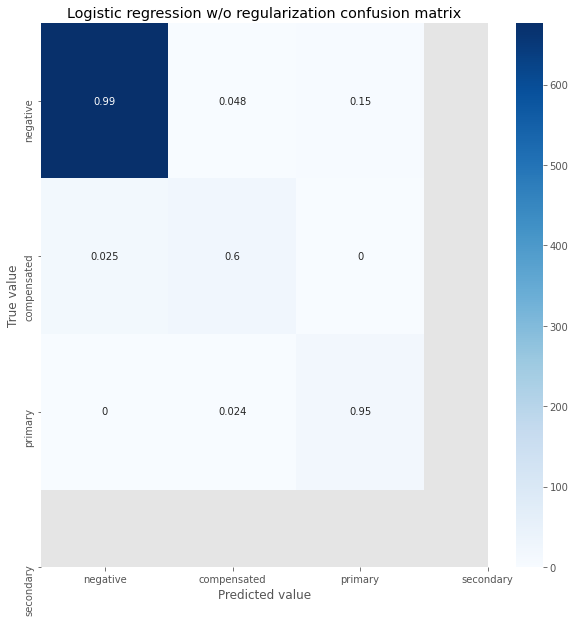

In [ ]:
# Confusion matrix visualization for the model
conf_matrix(y_test, predictions, 'Logistic regression w/o regularization')

* the same problem - no secondary hypothyreoid class in test data, good resulta only for negative class

In [ ]:
# Cross-validation for the model
cross_validate(lr_wo, X_test, y_test, 5)

Cross-Validation Accuracy Scores:
 [0.95302013 0.95302013 0.95302013 0.9527027  0.9527027 ]
-------------------------------------------
Mean score:  0.9528931616179938


### 5.3. KNN

To find smallest K with the best metrics we can use following calculation and plotting.

Minimum error: - 0.021534320323014805 at K = 5


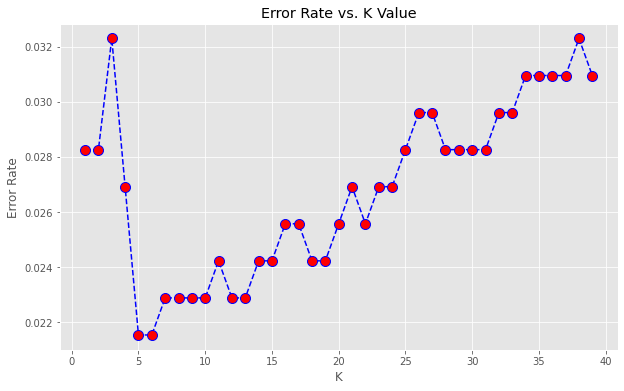

In [ ]:
# Calculating error between predicted and test values of y for different K
# Finding K-value for the smallest error
error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test.Class))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error: -",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

We can see that optimal number for K is 5, where will be the smallest error

In [ ]:
# KNN model with optimal 5 number of neighbors
knn = KNeighborsClassifier(n_neighbors = 5) 
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

In [ ]:
# Evaluating the model
evaluate_model(X_train, y_train, X_test, y_test, knn)

Test Accuracy 97.85%
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       681
           1       0.79      0.90      0.84        42
           2       0.90      0.95      0.93        20

    accuracy                           0.98       743
   macro avg       0.90      0.95      0.92       743
weighted avg       0.98      0.98      0.98       743



* For KNN model recall and f1-score are better then for logistic regression, but still the same problem with minority Class 3, which is not present at all due to unbalanced data

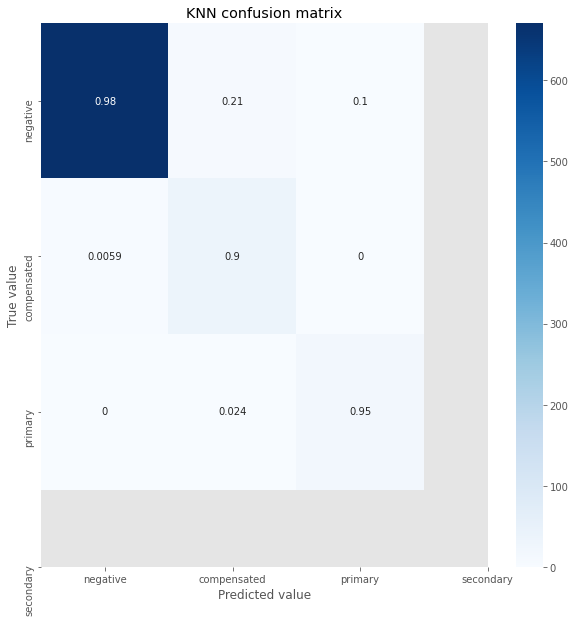

In [ ]:
# Confusion matrix visualization for the model
conf_matrix(y_test, predictions, 'KNN')

* and almost the same with confusion matrix, no secondary hypothyreoid on it and only negative class is good

In [ ]:
# Cross-validation for the model
cross_validate(knn, X_test, y_test, 5)

Cross-Validation Accuracy Scores:
 [0.95973154 0.95302013 0.98657718 0.97297297 0.97297297]
-------------------------------------------
Mean score:  0.9690549610012698


* Cross-validation score is better, but accuracy is not informative in this case untill data in unbalanced

### 5.4. Fixing unbalanced data

* As we saw from previous analysis our data is very unbalanced in terms of target classes
* To fix this SMOTE technique will be used as it synthesises new minority instances between existing (real) minority instances, and that's exactly what we need 

In [ ]:
# Resampling X and y datasets with SMOTE technique
sm = SMOTE(k_neighbors=1, random_state=SEED)
X_sm, y_sm = sm.fit_resample(X_tr, y)

In [ ]:
# Checking classes sizes changed after SMOTE
print('y after SMOTE:\n', pd.DataFrame(y_sm).value_counts())

y after SMOTE:
 3    3420
2    3420
1    3420
0    3420
dtype: int64


* For fixing unbalanced data with SMOTE I had one doubt -> in our case it is possible to use only 1 as number for k_neighbors as the smallest Class has only 2 samples(not sure why not 2, but it allowed me to do only with one). But it the end it worked good so I left this method in the work.
But I'm not sure if 1 neighbor is enough for good balance.
* I've tried to fix undersample with RamdomUnderSample() which doesn't has such restrictions, but code below didn't work for me, and I had an error regarding pipline which I couldn't resolve. I'll leave it here, may be you could give some suggestions what I did wrong, thanks

In [ ]:
# oversample = SMOTE(k_neighbors=1, random_state=SEED)
# undersample = RandomUnderSampler()
# steps = [('o', oversample), ('u', undersample)]
# pipeline = Pipeline(steps=steps)
# X_sm, y_sm = pipeline.fit_resample(X, y)

In [ ]:
# Splitting on train and test with new balanced data
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, 
                                                  random_state=SEED, test_size = 0.2)

#### **Logistic regression**

In [ ]:
# Fitting logistic regression with resampled data
lr_wo = LogisticRegression(penalty='none')
lr_wo.fit(X_train_sm, y_train_sm)
predictions = lr_wo.predict(X_test_sm)

In [ ]:
# Evaluating Logistic regression model after resampling
evaluate_model(X_train_sm, y_train_sm, X_test_sm, y_test_sm, lr_wo)

Test Accuracy 99.20%
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       701
           1       0.98      1.00      0.99       689
           2       1.00      1.00      1.00       675
           3       1.00      1.00      1.00       671

    accuracy                           0.99      2736
   macro avg       0.99      0.99      0.99      2736
weighted avg       0.99      0.99      0.99      2736



* As we can see our metrics look very good now, recall is perfect for all classes with diseases and f1 is also very good, even precision and accuracy are very high

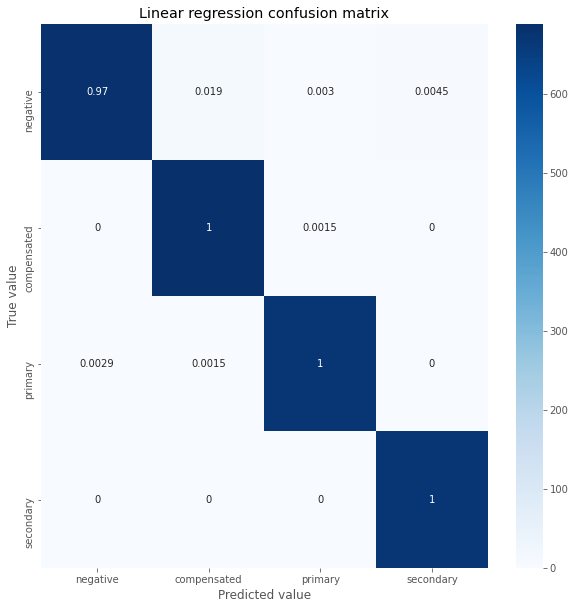

In [ ]:
# Visualization of confusion matrix after resampling
conf_matrix(y_test_sm, predictions, 'Linear regression')

* confusion matrix looks very good for this model, we have all classes now

In [ ]:
# Cross-validation for the model
cross_validate(lr_wo, X_test_sm, y_test_sm, 5)

Cross-Validation Accuracy Scores:
 [0.99087591 0.98537477 0.98354662 0.98720293 0.99634369]
-------------------------------------------
Mean score:  0.9886687839442747


* Cross-validation score doesn't differ a lot and is also very good

#### **KNN**

In [ ]:
# Fitting KNN model with resampled data
knn = KNeighborsClassifier(n_neighbors = 5) 
knn.fit(X_train_sm, y_train_sm)
predictions = knn.predict(X_test_sm)

In [ ]:
# Evaluating KNN model after resampling
evaluate_model(X_train_sm, y_train_sm, X_test_sm, y_test_sm, knn)

Test Accuracy 99.16%
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       701
           1       0.98      0.99      0.98       689
           2       0.99      1.00      1.00       675
           3       1.00      1.00      1.00       671

    accuracy                           0.99      2736
   macro avg       0.99      0.99      0.99      2736
weighted avg       0.99      0.99      0.99      2736



* For KNN also after resampling situation changed in better side, all scores are very high, total accuracy and recall for 1 Class is slightly lower then for logistic regression, but difference is very small

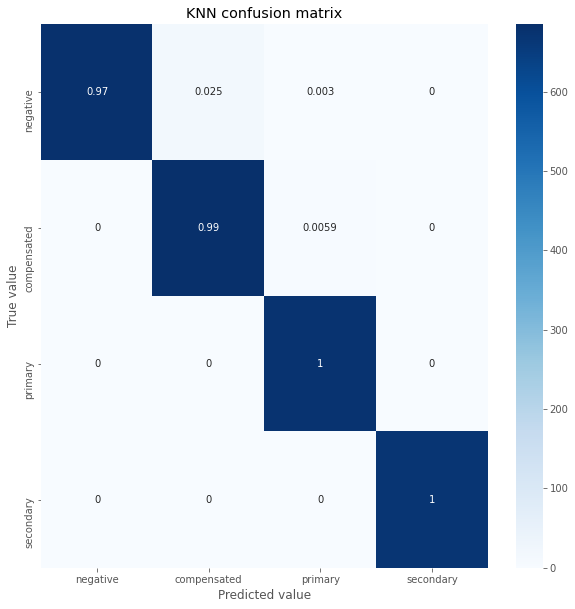

In [ ]:
# Visualization of confusion matrix after resampling
conf_matrix(y_test_sm, predictions, 'KNN')

* confusion matrix looks very good also as we have all classes for this model too

In [ ]:
# Cross-validation for the model
cross_validate(knn, X_test_sm, y_test_sm, 5)

Cross-Validation Accuracy Scores:
 [0.99087591 0.97989031 0.98354662 0.97989031 0.98537477]
-------------------------------------------
Mean score:  0.9839155846755361


* Cross-validation score doesn't differ a lot and is also very good

### 5.5. Hyperparameters tuning and feature selection

#### **hyperparameters tuning**

In [ ]:
# Creating parameters grid for Grid Search for Logistic regression
param_grid = [
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
     'C': np.logspace(-4, 4, 20),
     'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag'],
     'max_iter': [100, 1000]
     }
]

In [ ]:
# Creating GridSearch instance with parameters grid
clf = GridSearchCV(lr, param_grid=param_grid, cv=2, verbose=True, n_jobs=-1)

In [ ]:
best_clf = clf.fit(X_train_sm, y_train_sm)

Fitting 2 folds for each of 640 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 838 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed: 10.8min finished


In [ ]:
# Checking for best estimator with best hyperparameters
best_clf.best_estimator_

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Accuracy score for best estimator
best_clf.score(X_test_sm, y_test_sm)

0.9923245614035088

* Score is very slightly better then for usual logistic regression model, so will check other metrics as well

In [ ]:
# Model with the best hyperparameters
lr_hyp = LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
lr_hyp.fit(X_train_sm, y_train_sm)
predictions = lr_hyp.predict(X_test_sm)

In [ ]:
# Evaluating Logistic regression with the best hyperparameters
evaluate_model(X_train_sm, y_train_sm, X_test_sm, y_test_sm, lr_hyp)

Test Accuracy 99.23%
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       701
           1       0.98      1.00      0.99       689
           2       1.00      1.00      1.00       675
           3       0.99      1.00      1.00       671

    accuracy                           0.99      2736
   macro avg       0.99      0.99      0.99      2736
weighted avg       0.99      0.99      0.99      2736



* For recall and f1-score nothing  changed, but we can left those hyperparameters just to have a little bit better accuracy, which now makes sence as our data is balanced

#### **feature selection**

In [ ]:
# Using SelectFromModel for finding most useful features
sel = SelectFromModel(lr_hyp)
sel.fit(X_train_sm, y_train_sm)
sel.get_support()

array([False, False, False, False, False, False,  True, False,  True,
       False,  True,  True,  True,  True, False, False])

In [ ]:
# mapping feature names with values from SelectFromModel
best_features = pd.DataFrame(sel.get_support())
best_features.index = X.columns
best_features.sort_values(by=0, ascending=False)

,0
psych,True
TSH,True
TT4_measured,True
TT4,True
T4U_measured,True
T4U,True
age,False
sex,False
on_thyroxine,False
query_hypothyroid,False


* We have here 6 most important features for our model: TSH, TT4 and it's TT4_measured, T4U and it's T4U_measured and psych feature

### 5.6. Conclusions:
* After balancing data we can see from metrics that Logistic regression with selected hyperparameters is the best model for our classification problem
* There are 6 most important features which predict target class
* KNN model also worked very good after data balancing and has result which is very close to logistic regression